In [7]:
%load_ext autoreload
%autoreload 2

import torch

from rl4co.envs import CVRPEnv, CVRPTWEnv
from rl4co.models.nn.utils import rollout, random_policy
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
scale = False
env = CVRPTWEnv(
    num_loc=20,
    min_loc=0,
    max_loc=150,
    min_demand=1,
    max_demand=10,
    vehicle_capacity=1,
    capacity=10,
    min_time=0,
    max_time=480,
    scale=scale,
)

Start rollout...
Done.
Finished run with reward:
 tensor([-3107.8325, -2237.1101, -3366.8000]) 
actions:
 tensor([[11,  5, 14,  0, 15,  0, 12,  7,  0, 13, 16,  0, 20,  0,  1, 10,  0, 17,
          8,  0,  9,  3,  0,  4,  0, 18,  0, 19,  0,  2,  0,  6,  0,  0,  0],
        [12, 17, 16,  0, 18,  0, 20,  1,  0,  8,  2,  0,  3, 14,  0,  9, 10,  0,
         13,  0,  6, 15,  0,  4,  0, 19,  5,  0,  7,  0, 11,  0,  0,  0,  0],
        [13,  4,  0,  5,  0, 14,  7,  0,  8,  0,  9,  0, 12,  0,  1,  0, 16, 18,
         11,  0,  2,  0,  6,  0, 17,  0,  3,  0, 20,  0, 15,  0, 10,  0, 19]])


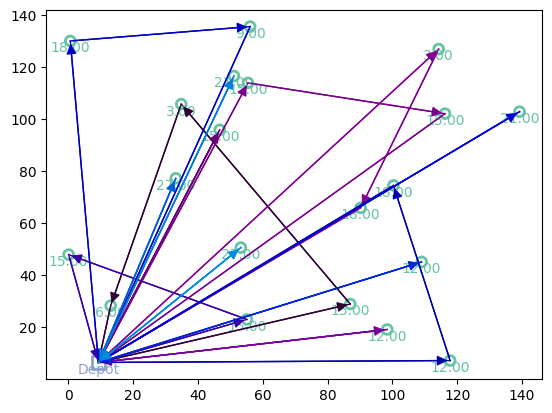

In [9]:
# try random policy with a random instance
batch_size = 3

print("Start rollout...")
reward, td, actions = rollout(
    env=env, td=env.reset(batch_size=[batch_size]), policy=random_policy, max_steps=100
)
print("Done.")
print("Finished run with reward:\n", reward, "\nactions:\n", actions)
env.render(td, actions)

Start attention model...


/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Tour lengths: ['2283.72', '3198.19', '3389.07']


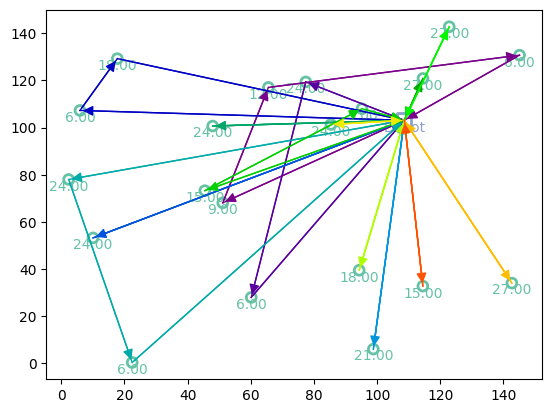

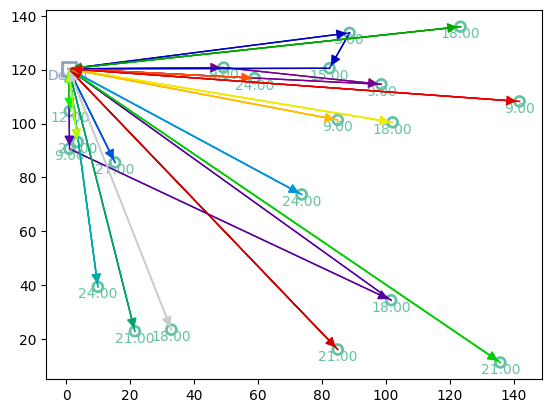

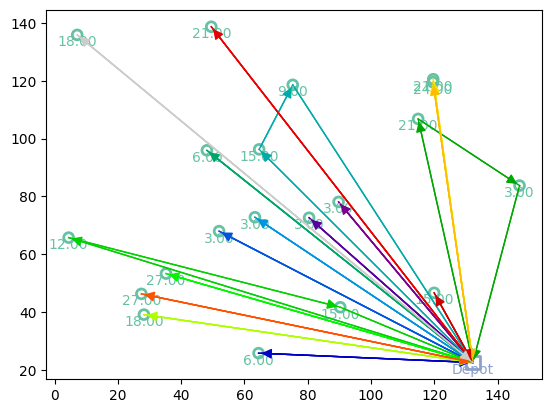

In [10]:
# Model: default is AM with REINFORCE and greedy rollout baseline
print("Start attention model...")
model = AttentionModel(
    env, baseline="rollout", train_data_size=100_000, val_data_size=10_000
)

# Greedy rollouts over untrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:43: attribute 'env' removed from hparams because it cannot be pickled
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | CVRPTWEnv            | 0     
1 | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/datasets/nayeli/rl4co/venv-rl4co/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


Tour lengths: ['2089.84', '2852.36', '2473.74']


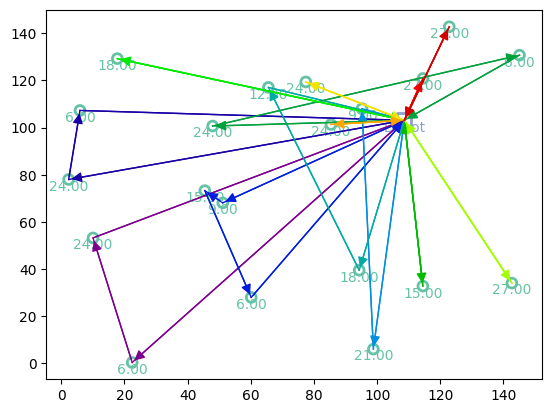

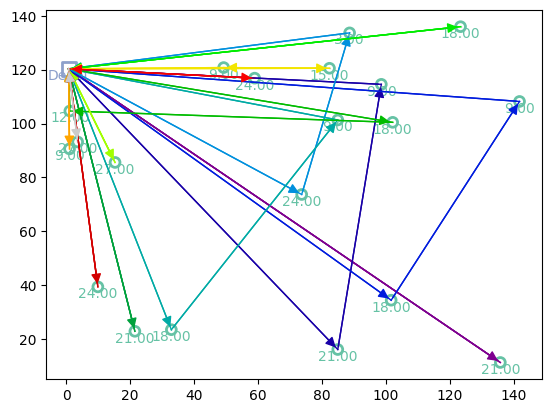

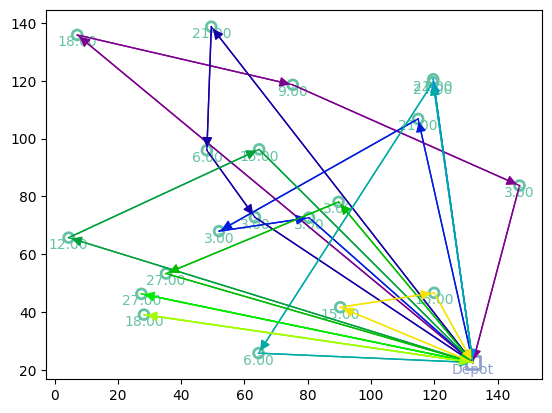

In [11]:
# The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="auto",
    devices=1,
    logger=None,
)
# fit model
trainer.fit(model)

# Testing

# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | CVRPTWEnv            | 0     
1 | policy   | AttentionModelPolicy | 694 K 
2 | baseline | WarmupBaseline       | 694 K 
--------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.557     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Tour lengths: ['1998.63', '2682.42', '2338.45']


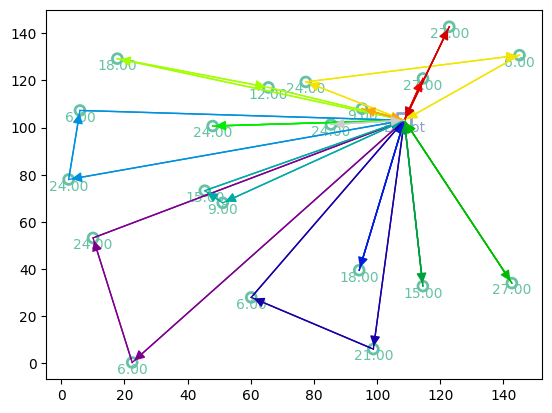

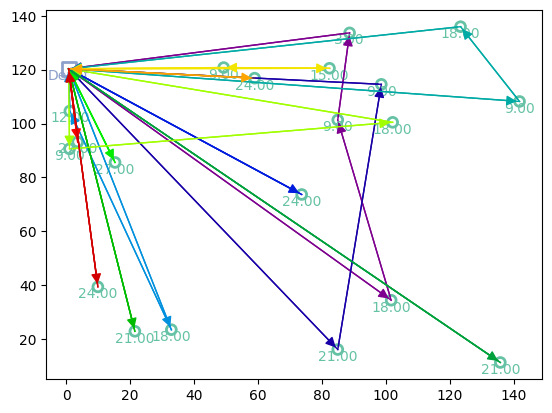

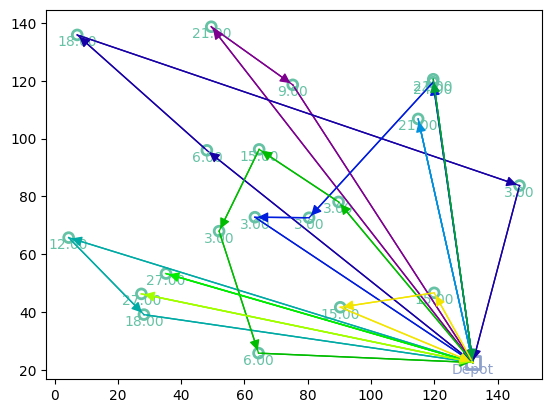

In [12]:
# The RL4CO trainer is a wrapper around PyTorch Lightning's `Trainer` class which adds some functionality and more efficient defaults
trainer = RL4COTrainer(
    max_epochs=30,
    accelerator="auto",
    devices=1,
    logger=None,
)
# fit model
trainer.fit(model)

# Testing

# Greedy rollouts over trained model (same states as previous plot)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)

# Plotting
print(f"Tour lengths: {[f'{-r.item():.2f}' for r in out['reward']]}")
for td, actions in zip(td_init, out["actions"].cpu()):
    env.render(td, actions)